In [ ]:
pip install transformers datasets accelerate #Installing required Libraries

In [ ]:
!unzip MMU-Iris-Database.zip -d ./data

Archive:  MMU-Iris-Database.zip
replace ./data/MMU-Iris-Database/aeval/left/aeval1.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# Importing Libraries using PIL, and implementing cross folding technique. Created a dataset using the imported images, the labels were taken from folder names.

from PIL import Image
import os
import random
from datasets import Dataset

def import_images(root_dir, target_size=(192, 192)):
    # Create lists to store the imported data
    file_paths = []
    images = []
    labels = []

    # Iterate through the folders in the root directory
    for label_folder in os.listdir(root_dir):
        label_path = os.path.join(root_dir, label_folder)

        if os.path.isdir(label_path):
            # Check for left and right folders
            left_folder = os.path.join(label_path, 'left')
            right_folder = os.path.join(label_path, 'right')

            if os.path.exists(left_folder) and os.path.exists(right_folder):
                # Get the list of files in the left and right folders
                left_files = [file for file in os.listdir(left_folder) if file.lower().endswith('.bmp')]
                right_files = [file for file in os.listdir(right_folder) if file.lower().endswith('.bmp')]

                # Check if there are bmp files in the folders
                if left_files and right_files:
                  for i in range(len(left_files)):
                    # Get the file paths
                    # Take the first left and right images
                    left_image_path = os.path.join(left_folder, left_files[i])
                    right_image_path = os.path.join(right_folder, right_files[i])

                    # Open the images using PIL
                    left_image = Image.open(left_image_path)
                    right_image = Image.open(right_image_path)

                    # Resize images to the target size
                    left_image = left_image.resize(target_size)
                    right_image = right_image.resize(target_size)

                    # Create a matrix for the target image
                    target_image = Image.new("RGB", (target_size[0], target_size[1]))

                    # Randomly choose pixels from each image and fill the target image matrix
                    for i in range(target_size[0]):
                        for j in range(target_size[1]):
                            if random.choice([True, False]):
                                target_image.putpixel((i, j), left_image.getpixel((i, j)))
                            else:
                                target_image.putpixel((i, j), right_image.getpixel((i, j)))

                    # Append the data to the lists
                    file_paths.append(f'{label_folder}_crossfolded.jpg')
                    images.append(target_image)
                    labels.append(label_folder)

    # Create a Hugging Face Dataset dictionary
    dataset_dict = {
        "image_file_path": file_paths,
        "image": images,
        "labels": labels,
    }

    # Convert to Hugging Face Dataset
    dataset = Dataset.from_dict(dataset_dict)

    return dataset

In [ ]:

# Specify the root directory containing the labeled folders
root_directory = 'data/MMU-Iris-Database'

# Import images and create the Hugging Face Dataset
dataset = import_images(root_directory)

# Access the Hugging Face Dataset (example for the first entry)
example_entry = dataset[0]
print(example_entry)

{'image_file_path': 'ongbll_crossfolded.jpg', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=192x192 at 0x790AFBA018D0>, 'labels': 'ongbll'}


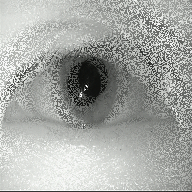

In [ ]:
import matplotlib.pyplot as plt

dataset[0]['image']

In [ ]:
dataset

Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 225
})

In [ ]:
# Implemented data augmentation using trochvision - transforms, applied horizontal flip, crop, rotation and color adjustments. The modified dataset contains x2 size of original data.

from PIL import Image, ImageOps
from torchvision import transforms
from datasets import Dataset


# Define data augmentation transforms for PIL images
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(size=(192, 192), scale=(0.8, 1.0)),
])

# Create a new dataset to store both original and augmented images
combined_data = {
    "image_file_path": [],
    "image": [],
    "labels": [],
}

# Add original images to the new dataset
combined_data["image_file_path"].extend(dataset["image_file_path"])
combined_data["image"].extend(dataset["image"])
combined_data["labels"].extend(dataset["labels"])

# Apply data augmentation and add augmented images to the new dataset
for image, label, file_path in zip(dataset["image"], dataset["labels"], dataset["image_file_path"]):
    augmented_image = data_transform(image)

    # Append augmented image and corresponding label to the new dataset
    combined_data["image_file_path"].append(f"{file_path}_augmented.jpg")  # Adjust the filename as needed
    combined_data["image"].append(augmented_image)
    combined_data["labels"].append(label)

# Create a new dataset with both original and augmented images
combined_dataset = Dataset.from_dict(combined_data)

# Now augmented_dataset contains augmented images in PIL format with unchanged labels
# You can use it for training


In [ ]:
# Implemented train-test-split
combined_dataset = combined_dataset.shuffle(seed=42)
data = combined_dataset.train_test_split(test_size=0.2)
data

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 360
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 90
    })
})

In [ ]:
# Imported Vision Trnasformer fro Huggingface transformers library

from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)


In [ ]:
def process_example(example):
    inputs = processor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [ ]:
type(combined_dataset[0]['image'])

PIL.PngImagePlugin.PngImageFile

In [ ]:
# Applied Image processing using VITImageProcessor
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

In [ ]:
prepared_ds = data.with_transform(transform)

In [ ]:
prepared_ds['train'][0]

{'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 'labels': 'tickl'}

In [ ]:
# Checking for number of classes
unique_labels = []
for x in dataset['labels']:
    if x not in unique_labels:
        unique_labels.append(x)
print(unique_labels)

['ongbll', 'aeval', 'lpjl', 'weecml', 'christinel', 'bryanl', 'suzailil', 'mimil', 'tonghll', 'vimalal', 'hockl', 'tingcyl', 'lowyfl', 'salal', 'philipl', 'lec', 'kelvinl', 'eugenehol', 'tickl', 'nkll', 'thomasl', 'sarinal', 'tanwnl', 'yannl', 'zulaikahl', 'mahskl', 'pcll', 'lokel', 'masl', 'winl', 'norsuhaidahl', 'fional', 'zaridahl', 'roslil', 'liujwl', 'ngkokwhyl', 'maranl', 'chingycl', 'mazwanl', 'minglil', 'chualsl', 'chongpkl', 'norazal', 'fatmal', 'sitil']


In [ ]:
# Implemented Collate Function for trainer model
import torch

label_encoder = {label: index for index, label in enumerate(unique_labels)}  # unique_labels should contain all unique label strings in your dataset

def collate_fn(batch):
    # Convert string labels to numerical format using label_encoder
    numerical_labels = [label_encoder[x['labels']] for x in batch]

    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor(numerical_labels)
    }



In [ ]:
# Compute Metrics function for computing accuracy

import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


<ipython-input-17-3044fb6e3895>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
dir(dataset.features['labels'])

['__annotations__',
 '__call__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_type',
 'dtype',
 'encode_example',
 'id',
 'pa_type']

In [ ]:
# Importing ViTForImageClassification from transformeres library

from transformers import ViTForImageClassification

labels = dataset['labels']

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# declaring Hyperparameters for the model to train on.

from transformers import TrainingArguments, get_cosine_schedule_with_warmup, Trainer

# Training arguments
training_args = TrainingArguments(
    output_dir="./vit-base-beans",
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=8,  # Increase the number of epochs
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

In [ ]:
# Using AdamW optimizer with get_cosine_with_warmup_steps

from transformers import AdamW
# Optimizer with cosine annealing and warm-up
num_training_steps = len(prepared_ds["train"]) // training_args.per_device_train_batch_size * training_args.num_train_epochs
optimizer_params = {
    "lr": training_args.learning_rate,
    "eps": 1e-8,
    "weight_decay": 0.01,
}
optimizer = AdamW(model.parameters(), **optimizer_params)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_training_steps // 10, num_training_steps=num_training_steps)



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# declaring trainer object

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    tokenizer=processor,
    optimizers=(optimizer, scheduler),  # Add scheduler
)


In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()
# Running train on train datset, got ccuracy of 82%

Step,Training Loss,Validation Loss,Accuracy
100,2.700800,3.027279,0.822222


***** train metrics *****
  epoch                    =         8.0
  total_flos               = 208265137GF
  train_loss               =      3.1842
  train_runtime            =  0:01:08.54
  train_samples_per_second =      42.018
  train_steps_per_second   =       2.684


In [ ]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

# Running eval on validation set, accuracy - 82%

***** eval metrics *****
  epoch                   =        8.0
  eval_accuracy           =     0.8222
  eval_loss               =     3.0273
  eval_runtime            = 0:00:01.22
  eval_samples_per_second =     73.586
  eval_steps_per_second   =      9.811


In [ ]:
y_true = [label_encoder[x['labels']] for x in prepared_ds['test']]


In [ ]:
y_true

array([ 8, 43,  7, 29, 22, 36,  9, 35, 24, 39, 44, 44,  9, 38, 31, 41, 14,
       10,  8, 16,  3, 12, 27, 29, 23, 11, 44, 31,  5, 35,  9, 16, 23, 33,
       40, 10,  3, 12,  4,  6, 34, 14,  2, 36, 17,  3, 43, 41, 29, 15, 29,
       33, 32, 21, 42,  6, 31, 30, 43, 23,  7, 26, 19,  3, 15, 23, 15, 14,
       25, 35, 25, 23, 35,  9,  7, 43, 25, 18, 18,  8,  8, 38, 25, 26,  4,
        3,  5, 11, 20, 37])

In [ ]:
y_pred = np.argmax(trainer.predict(prepared_ds['test']).predictions, axis=1)

array([ 8, 43,  7, 29, 22, 36,  9, 35, 24, 39, 44, 44,  9, 38, 31, 41, 14,
       10,  0, 16, 37, 12, 27, 28, 41, 11, 17, 31,  5, 35, 41, 16, 41, 33,
       21, 10,  3, 12,  4,  6, 34, 14,  2, 36, 17, 37, 43, 41, 28, 15, 22,
       33, 32, 21, 42,  6, 31, 30, 43,  8, 30, 26, 19,  3, 15, 41, 15, 14,
       25, 35, 25, 23, 35,  9,  7, 43, 25, 18, 18,  0,  8, 38, 25, 26,  4,
       37,  5, 11, 20, 37])

In [ ]:
ypred = [x for x in y_pred]

In [ ]:
# Example: Get predictions on the validation set
predictions = trainer.predict(trainer.eval_dataset)

# Extract logits from the predictions
logits = predictions.predictions

# Convert logits to probabilities using softmax
probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)

In [ ]:
probs

tensor([[0.0221, 0.0099, 0.0087,  ..., 0.0025, 0.0023, 0.0023],
        [0.0119, 0.0205, 0.0102,  ..., 0.0029, 0.0033, 0.0030],
        [0.0132, 0.0110, 0.0219,  ..., 0.0023, 0.0024, 0.0024],
        ...,
        [0.0105, 0.0115, 0.0120,  ..., 0.0023, 0.0021, 0.0023],
        [0.0204, 0.0172, 0.0110,  ..., 0.0021, 0.0025, 0.0024],
        [0.0105, 0.0077, 0.0114,  ..., 0.0026, 0.0027, 0.0029]])

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, ypred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         1
           3       1.00      0.40      0.57         5
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      0.67      0.80         3
           8       0.67      0.50      0.57         4
           9       1.00      0.75      0.86         4
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00         2
          17       0.50      1.00      0.67         1
          18       1.00      1.00      1.00         2
          19       1.00    

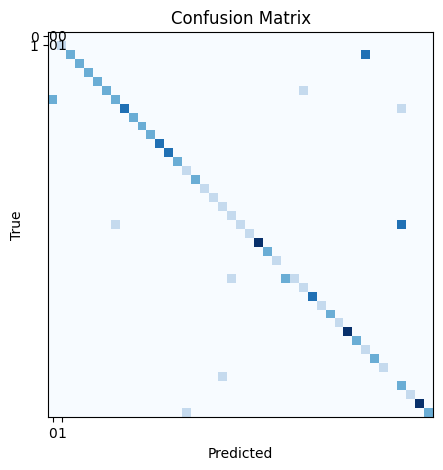

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split



# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)


# Plotting
fig, (ax1) = plt.subplots(1, figsize=(15, 5))

# Confusion Matrix
ax1.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax1.set_title('Confusion Matrix')
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')
ax1.grid(False)
for i in range(2):
    for j in range(2):
        ax1.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
